# Train Mask RCNN

In [1]:
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import torch.utils.data
import cv2
import torchvision.models.segmentation
import torch
import os
from matplotlib import pyplot as plt

In [2]:
# Get the training parameters.
BATCH_SIZE  = 4
IMG_SIZE    = [1024, 1024]

In [3]:
# Get the dataset sources.
DATASET_IMGS = "../Data/Images"
DATASET_SEGM = "../Data/instance_segmentation"
LABELS_NAMES = "../Data/bounding_box"

DATASET_SEPA = "../Data/isolated_strawberrys"
DATASET_CROP = "../Data/isolated_strawberrys_cropped"

In [4]:
# Euclidean distance.
def eucl_box(x1, y1, x2, y2):

    dist_1 = np.sqrt(np.sum((np.array([x1, y1]) - np.array([x2, y2])) ** 2))

    return dist_1

def load_bounding_boxes(filename):

    f = open(filename, "r")
    lines = f.readlines()

    boxes = []

    for line in lines:

        elements = line.split(' ')
    
        # Transform them.
        id, cent_x, cent_y, width, height = elements
        id = int(id)
        cent_x, cent_y, width, height = [float(x) for x in [cent_x, cent_y, width, height]]

        boxes.append([id, cent_x, cent_y, width, height])

    return boxes

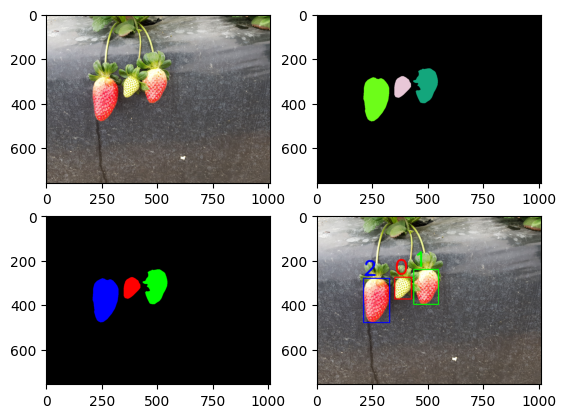

In [7]:
# Load the image.
img = cv2.imread(DATASET_IMGS + "/" + '10.png')
mask = cv2.imread(DATASET_SEGM + "/" + '10.png', 0)

# Get the masks.
masks_labels = [l for l in np.unique(mask) if l != 0]

# get the number ID and the height and width.
height, width = mask.shape
img_id = '10'

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

out_picture = img.copy().astype('uint8')
out_segmentation = np.zeros_like(img).astype('uint8')
out_segmentation_class = np.zeros_like(img).astype('uint8')
out_bounding_box = img.copy().astype('uint8')

label_colours = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

# Iterate through the labels to get the masks.
for num, label_id in enumerate(masks_labels):

    # Get that label as an isolated mask.
    mask_i = (mask == label_id).astype(np.uint8)  # Read vesse instance mask

    # Get the bounding box.
    bb_coords = cv2.findNonZero(mask_i)
    mask_bb_x, mask_bb_y, mask_bb_w, mask_bb_h = cv2.boundingRect(bb_coords)
    bb_cent = (mask_bb_x + mask_bb_w / 2, mask_bb_y + mask_bb_h / 2)

    min_distance = height * height
    best_box = None
    for box in load_bounding_boxes(LABELS_NAMES + '/' + img_id + '.txt'):

        # Transform them into the good gormat.
        box_id, box_cent_x, box_cent_y, box_width, box_height = box
        box_cent_x *= width
        box_cent_y *= height
        box_width *= width
        box_height *= height

        dist = eucl_box(box_cent_x, box_cent_y, bb_cent[0], bb_cent[1])

        if dist < min_distance:
            min_distance = dist
            best_box = (box_id, int(box_cent_x), int(box_cent_y))

    # Display this image.
    label = ['unripe', 'partially_ripe', 'fully_ripe'][best_box[0]]
    label = ['0', '1', '2'][best_box[0]]

    out_segmentation += (cv2.merge([mask_i, mask_i, mask_i]) * np.array([random.randrange(0, 255), random.randrange(0, 255), random.randrange(0, 255)])).astype('uint8')
    out_segmentation_class += (cv2.merge([mask_i, mask_i, mask_i]) * np.array(label_colours[best_box[0]])).astype('uint8')

    out_bounding_box = cv2.rectangle(out_bounding_box, (mask_bb_x, mask_bb_y), (mask_bb_x + mask_bb_w, mask_bb_y + mask_bb_h), label_colours[best_box[0]], 4)
    out_bounding_box = cv2.putText(out_bounding_box, label, (mask_bb_x, mask_bb_y - 15), cv2.FONT_HERSHEY_SIMPLEX, 3, label_colours[best_box[0]], 8)

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(out_picture)
axarr[0,1].imshow(out_segmentation)
axarr[1,0].imshow(out_segmentation_class)
axarr[1,1].imshow(out_bounding_box)
plt.show()